# 历史旱涝数据说明



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import os
from hydra import compose, initialize

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from shifting_baseline.data import HistoricalRecords
from mksci_font import config_font
from shifting_baseline.constants import LABELS, STAGES_BINS

config_font({"font.size": 9})

# The commented out code is creating an instance of the `HistoricalRecords` class from the `shifting_baseline.api.series` module. It is passing the `shp_path` and `data_path` parameters to the constructor of `HistoricalRecords` class using values from `cfg.ds.atlas.shp` and `cfg.ds.atlas.file` respectively.
history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std=cfg.to_std,
)

# 对比重建数据和历史数据

- 历史数据来自《中国千年旱涝图集》
- 重建数据来自 NOAA 的树轮重建数据


Millennial-scale data reveals collective memory of extreme events The impact of extreme weather events such as droughts and floods is intensifying, one important reason being that society quickly forgets past disasters and develops in disaster-prone areas. This collective memory of disasters has significantly affected a society's vulnerability to them. Still, there has long been a lack of data-driven measurements on how long this collective memory lasts. For the first time, we compared historical records with natural reconstructions over a millennium scale in China's Yellow River Basin, demonstrating that the collective memory of extreme climate lasts about 30 years (two generations). The current Earth System Models (ESMs), however, can not have sufficient spatial and temporal resolution to match this pattern, failing to capture the interactions between humans and extreme events. This finding emphasised the necessity of coupling environmental changes with human social systems and improving ESMs for the deep root of the Anthropocene.

## NOAA 树轮重建数据

In [4]:
combined = pd.read_csv(cfg.ds.out.tree_ring, index_col=0)
combined.head()

,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,0.304,0.537,-0.718,1.282
1001,-0.025,0.533,-1.023,0.984
1002,0.773,0.619,-0.334,1.984
1003,0.416,0.687,-0.891,1.703
1004,-0.220,0.640,-1.417,0.978


这里我们还可以用一张综合图来说明情况。

由于一般需要5个样本，计算标准差才有意义，所以我们的 `min_periods` 参数比 `windows` 至少要小 5。













开始计算历史数据和重建数据的相关性
cfg.agg_method=mean; cfg.to_int=True.


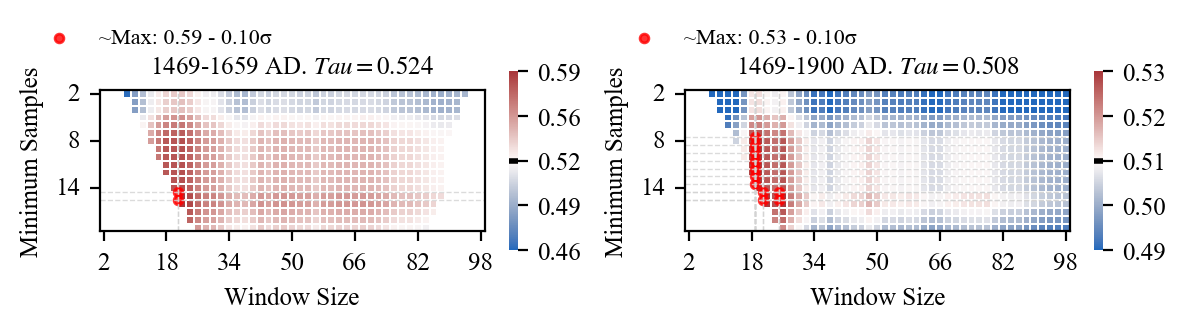

In [ ]:
from shifting_baseline.compare import experiment_corr_2d
from shifting_baseline.constants import STAGE1, STAGE2, END
from shifting_baseline.filters import calc_std_deviation

history.setup()

fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)
axs = axs.flatten()
# 实验参数
slice1 = slice(STAGE1, STAGE2)
slice2 = slice(STAGE1, END)

print("开始计算历史数据和重建数据的相关性")
print(f"cfg.agg_method={cfg.agg_method}; cfg.to_int={cfg.to_int}.")
for i, slice_now in enumerate([slice1, slice2]):
    data1, data2 = history.aggregate(
        cfg.agg_method,
        inplace=True,
        to_int=cfg.to_int,
    ).merge_with(
        combined["mean"],
        time_range=slice_now,
        split=True,
    )
    ax = axs[i]
    df, r_benchmark, ax = experiment_corr_2d(
        data1=data1,
        data2=data2,
        time_slice=slice_now,
        corr_method=cfg.corr_method,
        filter_func=calc_std_deviation,
        filter_side=cfg.filter_side,
        ax=ax,
        penalty=False,
        n_diff_w=5,
        std_offset=0.1,
    )
    ax.set_title(
        f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
        fontsize=9,
    )
    ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
    ax.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
    ax.tick_params(axis="both", rotation=0)
plt.show();

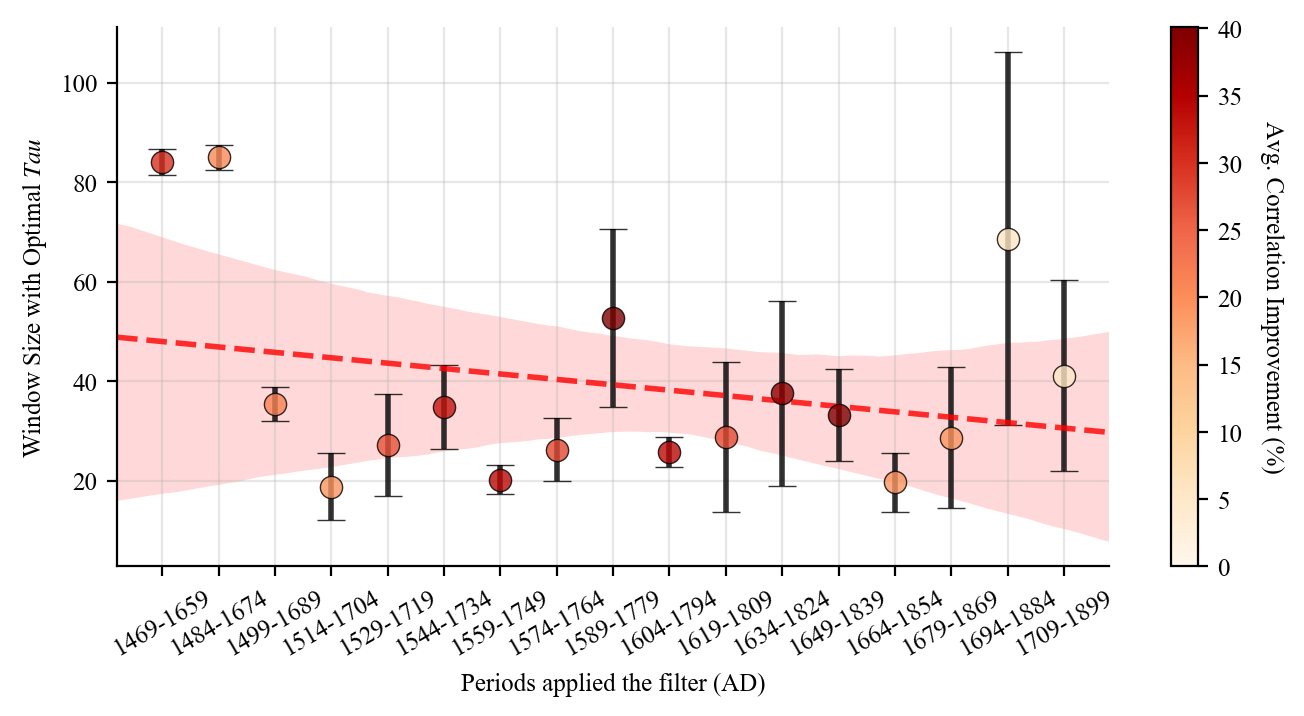

In [ ]:
from shifting_baseline.compare import sweep_slices
from shifting_baseline.filters import calc_std_deviation
from shifting_baseline.compare import sweep_max_corr_year

import matplotlib.pyplot as plt
from shifting_baseline.utils.plot import plot_correlation_windows

MINPERIOD = 5
# 生成所有可能的300年窗口
slices, mid_year, slice_labels = sweep_slices(
    start_year=STAGE1,
    window_size=190,
    step_size=15,
    end_year=END,
)

data1, data2 = history.merge_with(
    combined["mean"],
    split=True,
)
max_corr_year, max_corr = sweep_max_corr_year(
    data1=data1,
    data2=data2,
    slices=slices,
    corr_method=cfg.corr_method,
    windows=np.arange(2, 100),
    min_periods=np.repeat(MINPERIOD, 98),
    filter_func=calc_std_deviation,
)

# 使用函数
ax = plot_correlation_windows(
    max_corr_year,
    max_corr,
    mid_year,
    slice_labels,
)
lims = ax.get_xlim()
ax.set_xlim(lims)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.axvspan(1636, 1720, color="gray", alpha=0.2, label="Dynasty Transition")
# ax.legend()
plt.show();

### 综合作图

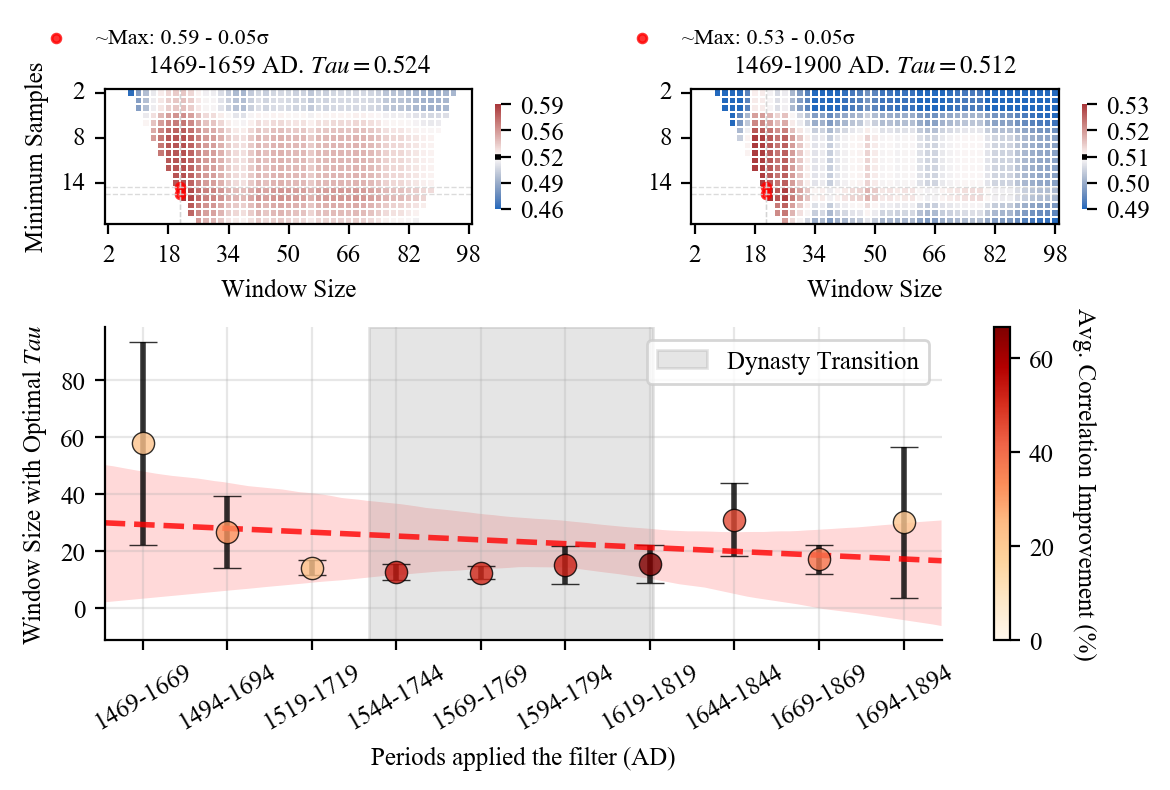

In [24]:
fig = plt.figure(figsize=(6, 4), constrained_layout=False)  # 增加高度

gs = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[1, 1.2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# 四次对比实验
for i, slice_now in enumerate([slice1, slice2]):
    ax = [ax1, ax2][i]
    df, r_benchmark, ax = experiment_corr_2d(
        data1=data1,
        data2=data2,
        time_slice=slice_now,
        corr_method=cfg.corr_method,
        filter_func=calc_std_deviation,
        filter_side=cfg.filter_side,
        ax=ax,
        penalty=False,
        n_diff_w=5,
        std_offset=0.05,
    )
    ax.set_title(
        f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
        fontsize=9,
    )
    ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
    ax.locator_params(axis="y", nbins=4)  # x轴最多9个主刻度
    ax.tick_params(axis="both", rotation=0)


# 绘制不同历史时期的窗口图
# 使用函数
# 使用函数
ax3 = plot_correlation_windows(
    max_corr_year,
    max_corr,
    mid_year,
    slice_labels,
    ax=ax3,
)
lims = ax3.get_xlim()
ax3.axvspan(1636, 1720, color="gray", alpha=0.2, label="Dynasty Transition")
ax3.set_xlim(lims)
ax3.legend()
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.legend()

ax2.set_ylabel("")
plt.tight_layout()
plt.show();